This lab was an introduction to reinforcement learning with simple statistical methods. The first exercise consists in a advertising problem. A website has the possibility to show an ad between A and B. The aim is to maximise the number of clicks on the ad, therefore the most attractive ad.
http://gerin.perso.math.cnrs.fr/Enseignements/TP_Bandits.pdf

In the second part, we train an algorithm to play Rock-Paper-Scissors. The algorithm plays numerous games against its opponent. When a new game starts at time t, it looks at the two games that were played last (so at times t-1 and t-2). It then looks in its memory when the same combination t-2 and t-1 was played, and what his opponent had played. It then choses the best outcome by looking at the simple probability of success based on experience.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import random

# A suboptimal approach: ε-exploration

Let us consider the following strategy:
􏰀 We chose E1 = A, E2 = B.

􏰀 For i ≥ 3, let Mi be the ad that has the best "clicking rate" up to now.

􏰀 With probability 1 − ε, we take Ei = Mi,

􏰀 With probability ε we take Ei = non(Mi).

# Question 2

In [45]:
def question2(epsilon, n = 1000, pA = 0.7, pB = 0.5):
#     Initialisation
    x = [] # liste de stockage des Xi
    E = [] #liste de stockage des couples (Ei, Xi)
    S = [] 
    
    
    x1 = isClique(pA)
    x2 = isClique(pB)
    x.append(x1)
    x.append(x2)
    E.append([pA,x1])
    E.append([pB,x2])
    S.append(x1)
    S.append((x1 + x2)/2)
    
    nbClicsA = x1
    nbClicsB = x2
    nbAffichagesA, nbAffichagesB = 1,1
    
    tauxA = tauxSucces(E, pA)
    tauxB = tauxSucces(E, pB)
    p=0
    
    
#     Récurrence
    for i in range(3, n):
        alea = random.random()
        if tauxA > tauxB: 
            if (1 - epsilon > alea):
                p = pA
                nbAffichagesA += 1
            else: 
                p = pB
                nbAffichagesB += 1
        elif tauxA < tauxB:
            if (1 - epsilon > alea):
                p = pB
                nbAffichagesB += 1
            else:
                p = pA
                nbAffichagesA += 1
        else:
            alea = random.random()
            if alea > 0.5:
                p = pA
                nbAffichagesA += 1
            else:
                p=pB
                nbAffichagesB += 1
        
        X = isClique(p)
        if p == pA:
            nbClicsA += X
        else:
            nbClicsB += X
        
        E.append((p,X))
        tauxA = nbClicsA / nbAffichagesA
        tauxB = nbClicsB / nbAffichagesB
        x.append(X)
        S.append(sum(x[:i])/i)
    return x
#     plt.plot(range(1,n,1), S, label = ""+ str(epsilon))
#     plt.legend()
#     plt.xlabel("number of clics")

def tauxSucces(E, p):
    s= 0
    for couple in E:
        if couple[0] == p:
            s += couple[1]
    publicites = [row[0] for row in E]     
    return s/(publicites.count(p))

def isClique(p):
    rand = random.random()
    if p> rand:
        return 1
    else:
        return 0
    
    

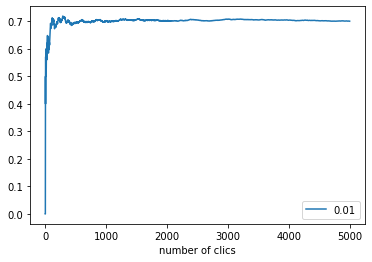

In [29]:
question2(0.01)

In [30]:
def differentsEpsilon():
# We test the function above for different values of epsilon
    for epsilon in [0.0001, 0.001, 0.01, 0.1]:
        print(question2(epsilon))

None
None
None
None


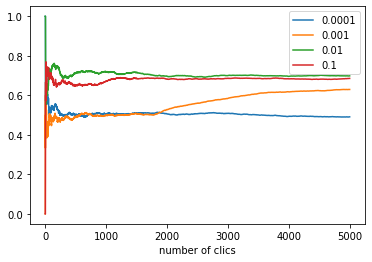

In [37]:
differentsEpsilon()

# Question 3 

In [67]:
def monte_carlo_estimate(n):
# This algorithm evaluates by the Monte Carlo method estimates of the curves:  

#                 1
#    i∈{1,...,n}􏰃→ -- * E[X1 +···+Xi]
#                 i
    X=[]
    res = []
    epsilon = 0.01
    for i in range (1, n):
        X.append(question2(epsilon))
    X = np.array(X) 
    S = []
    for k in range (1, n):
        S.append((X[:, k].sum())/n)
        res.append(sum(S[:k])/k)
    plt.plot(range(1,n,1), res)
    plt.xlabel("time")
    plt.title('Monte-Carlo estimation')
    
def multiple_mc_estimates(n, p):
# Here we simply compute n Monte Carlo estimates of size p
    for _ in range (n):
        monte_carlo_estimate(p)

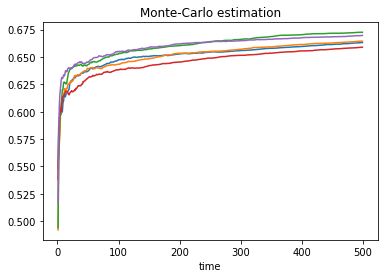

In [68]:
multiple_mc_estimates(5, 500)

# Pierre Feuille Ciseaux

Here we are trying to create an algorithm that learns his opponents' strategy at rock-paper-scissors and plays accordingly

In [69]:
def ReponseStrategie(L):
#This algorithm describes what response should be given to a strategy of an opponent.

#Input:
#     L: List(size = 3) representing the opponents "strategy". If L = [0.2, 0.3, 0.5], it 
#        means that the opponent plays Rock with probability 0.2, Paper with probability 0.3
#        and scissors with probability 0.5

#Output: 
#     List(size =3) representing the best move to play 


    coupJoue = np.argmax(L)
    if coupJoue ==  0:
        return [0,1,0]
    elif coupJoue == 1:
        return [0,0,1]
    else:
        return [1,0,0]
        

In [71]:
ReponseStrategie([0.2,0.3,0.5])

[1, 0, 0]

In [191]:
#This cell is dedicated to creating the strategie of our player

def apprentissage(epsilon, X, Y):
# This function returns the move played by our computer. He plays with what he has learned
# with a probability of 1 - epsilon, and plays randomly wih a probability of epsilon (he 
# "explores")

#Input:
#     epsilon: float, determines the way we play as described above
#     X: List, the list of plays we have done before
#     Y: List, the list of plays our opponent has done before

#Output:
#    List of size 3: Our play 
    alea = np.random.rand()
    if ((1-epsilon) > alea):
        L = occurencesEvenement(X,Y)
        if (len(L) != 0):
            S = statistiques_joueur(L)
            return ReponseStrategie(S)
        else:
            return randomMove(0.333, 0.333, 0.333)
            
    else:
        return randomMove(0.333, 0.333, 0.333)

    
    
def occurencesEvenement(X, Y):
# We look at the two last moves played by us and our opponent. We look if this sequence has
# already occured in the past and what our opponent had played.

# Input:
#     X: List, the list of plays we have done before
#     Y: List, the list of plays our opponent has done before

# Output:
#    S: the list of all the moves played by our opponent after the sequence of the two last
#       moves

##########################

    XTMoins1 = X[-1]
    YTMoins1 = Y[-1]
    XTMoins2 = X[- 2]
    YTMoins2 = Y[- 2]
    
    M = []
    for i in range (len(X) - 1):
        M.append([[X[i], Y[i]], [X[i+1], Y[i+1]]])
    
    derniereOccurence = [[XTMoins2, YTMoins2], [XTMoins1, YTMoins1]]
    S = []
    for i in range (len(M)-1):
        if derniereOccurence == M[i]:
            S.append(M[i+1][0][1])

    return S



def statistiques_joueur(S):
# When looking at a player's list of plays, gives the frequency of these plays

#Input:
#     S: list of plays of a player through time

#Output:
#     List of size 3: frequency of plays rock, paper, scissors

###########################

    pierre = 0
    feuille = 0
    ciseaux = 0
    n = len(S)
    for coup in S:
        pierre += coup[0]
        feuille += coup[1]
        ciseaux += coup[2]
        
    return [pierre/n, feuille/n, ciseaux/n]




def randomMove(a,b,c):
# Makes a random move: rock with prob a, paper with prob b, scissors with prob c

# Input:
#      a: float, prob of move rock
#      b: float, prob of move paper
#      c: float, prob of move scissors

# Output:
#     List of size 3, a random move

######################


    alea = np.random.rand()
    
    if (alea <= a):
        return [1,0,0]
    elif (a < alea <= a+b):
        return [0,1,0]
    else:
        return [0,0,1]

In [214]:
def simulateGame(time, opponent_strategy, epsilon = 0.1):
# Computes a game of rock paper scissors between our algorithm and a player that plays with
# a given strategy

# Input:
#      time: int, number of plays to compute
#      opponent_strategy: List(size = 3) of probabilities of plays of opponent

# Output:
#      Moi: list of plays made by our computer
#      Aversaire: list of plays made by our opponent

#############################


    Moi = []
    Adversaire = []
    for _ in range (3):
        Moi.append(randomMove(0.333, 0.333, 0.333))
        Adversaire.append(randomMove(*opponent_strategy))
    
    
    t = 0
    
    while (t < time):
        Moi.append(apprentissage(epsilon, Moi, Adversaire))
        Adversaire.append(randomMove(*opponent_strategy))
        t+= 1
    return Moi, Adversaire

In [224]:
def parties_gagnees(X,Y):
# This part is the post processing of the simulated games from the above function

# Input:
#      X: list, the plays made by our algorithm
#      Y: list, the plays made by our opponent

# Output:
#      String: describes the results of the match


#######################


    X_gagne = 0
    X_perd = 0
    nul = 0
    victoires, defaites, egalites = [], [], []
    a,b = outcome(X,Y)
    result = ['nul', 'gagne', 'perd']
    
    game_evolution = []
    
    for i in range (len(X)):
        res = result[ (convert_to_number(X[i]) - convert_to_number(Y[i])) % 3 ]
        game_evolution.append(res)
        if res == 'nul':
            nul +=1
            
        elif res == 'gagne':
            X_gagne += 1
            
        else:
            X_perd += 1
            
        victoires.append(X_gagne)
        defaites.append(X_perd)
        egalites.append(nul)
    
    plt.plot(victoires, label = 'victoires')
    plt.plot(defaites, label = 'défaites')
    plt.plot(egalites, label = 'égalités')
    plt.xlabel("nombre de parties")
    plt.legend()
    
    return("Notre algo gagne {} fois, perd {} fois et fait égalité {} fois".format(X_gagne, X_perd, nul))


def convert_to_number(L):
    if (L == [1,0,0]):
        return 1
    
    elif (L == [0,1,0]):
        return 2
    
    else:
        return 3
    


In [222]:
Moi, Adversaire = simulateGame(5000, [0.4, 0.3, 0.3])

'Notre algo gagne 1708 fois, perd 1577 fois et fait égalité 1718 fois'

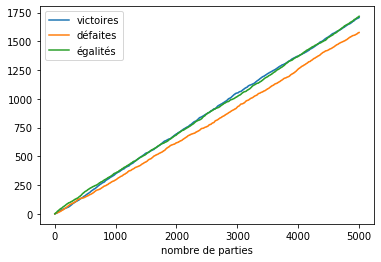

In [225]:
parties_gagnees(Moi, Adversaire)